# **Emotion Recognition from Speech using Mel Spectrograms and CNNs**

You can find all the details of the methods used in this notebook in the `REPORT.md` file on my [GitHub repository](https://github.com/SigurdST/emotion_recognition).

In [175]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Import the data
We use `librosa`, a package specialize in audio analysis.

In [256]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/d07 (3).wav,44100,3.032562


In [177]:
df_metadata.shape

(605, 4)

---

## **Data exploration**

### Waveform of the first file

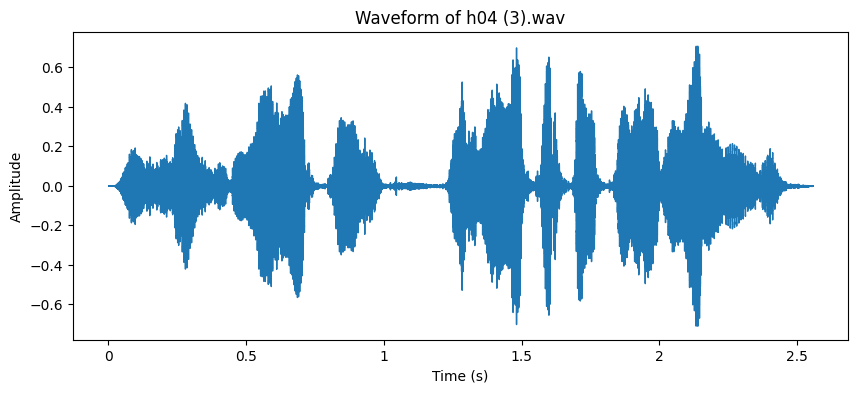

In [240]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Adding an *emotion* column

In [243]:
# Extract emotion labels from file names (the first letter of the file name indicates emotion)
df_metadata['emotion'] = df_metadata['file_name'].str[0]

# Map single-letter codes to emotion names
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

### Example of waveform for every emotion

In [255]:
# Obtaining the unique emotions
emotions = df_metadata['emotion'].unique()
files_per_emotion = {}

# Select one file per emotion
for emotion in emotions:
    files_per_emotion[emotion] = df_metadata[df_metadata['emotion'] == emotion].iloc[0]['file_path']

# Create a figure to plot the waveforms
plt.figure(figsize=(15, 10))

for i, (emotion, file_path) in enumerate(files_per_emotion.items(), 1):
    y, sr = librosa.load(file_path, sr=None)
    plt.subplot(3, 2, i) 
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/all_emotion/h04 (3).wav'

<Figure size 1500x1000 with 0 Axes>

### Histogram of audio durations

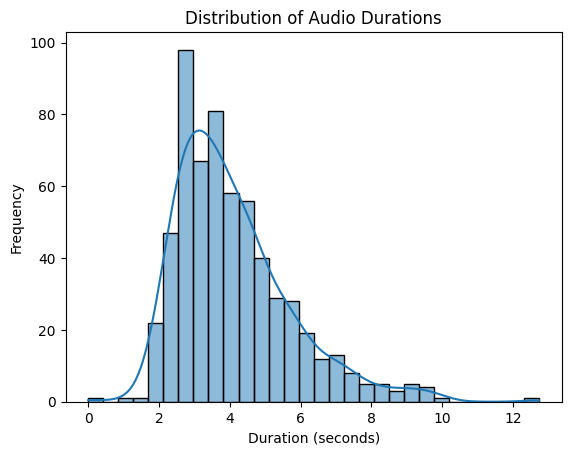

In [180]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

We observe that there is an audio with a duration of 0 second, we remove it

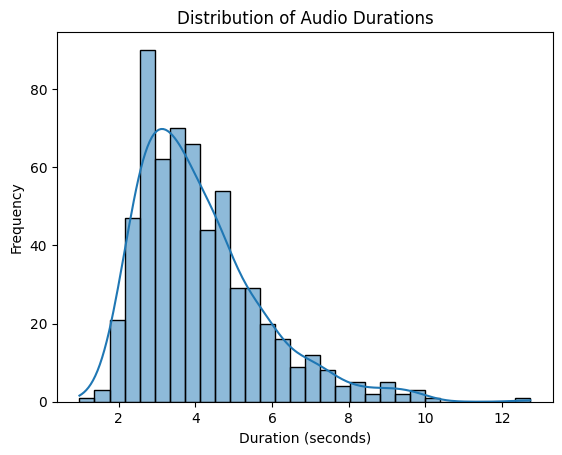

In [181]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

### Duration by emotion
Table :

In [245]:
# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()
emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,122.0,4.591546,2.049071,2.035828,3.174796,4.078628,4.986196,12.734853


Histograms :

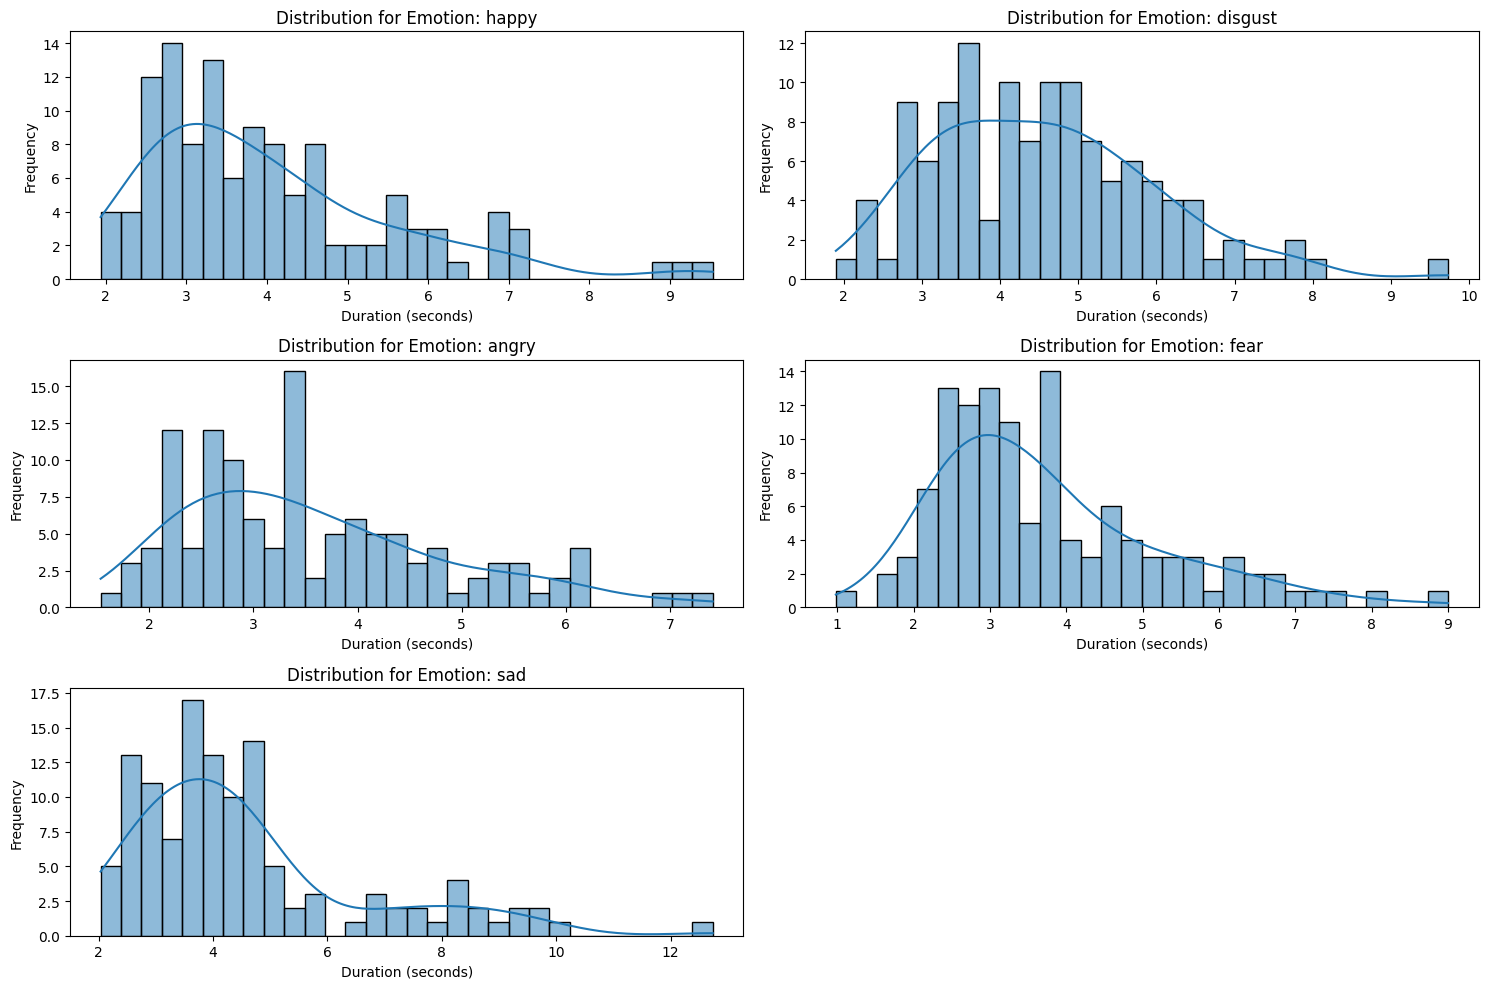

In [242]:
# Supposons que 'emotion' est une colonne dans df_metadata
categories = df_metadata['emotion'].unique()  # Obtenir les catégories uniques

# Créer une figure avec 5 plots (1 pour chaque catégorie)
plt.figure(figsize=(15, 10))  # Ajuster la taille globale

for i, category in enumerate(categories, 1):  # Boucle sur les catégories
    plt.subplot(3, 2, i)  # Disposer les plots en 3x2 (modifiez si nécessaire)
    sns.histplot(
        df_metadata[df_metadata['emotion'] == category]['duration_sec'],
        bins=30,
        kde=True
    )
    plt.title(f"Distribution for Emotion: {category}")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")

plt.tight_layout()  # Ajuster automatiquement l'espacement
plt.show()

We cannot observe important variation of duration according to emotion.

---

## **Data processing**

### Noise Reduction

We reduce noise using the `noisereduce` package.

In [246]:
import librosa.display
import noisereduce as nr


# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=None):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    noise_profile = y[:int(sr * 1)]

# Reduce noise
    y = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

### Mel spectogram
Mel spectrograms transform audio files into numeric representations using the Discrete Fourier Transform.

In [247]:
# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Function to visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

We create a column to store the mel spectrogram, and plot an example of a mel spectrogram for the first file.

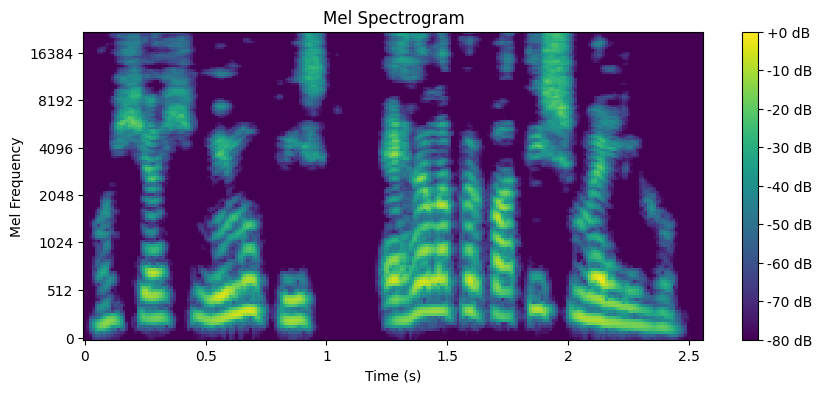

In [248]:
# We add a new column to store the Mel Spectrogram data
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
                
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Visualize the spectrogram for the first file
        if index == 0:
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

We export all the Mel spectrograms plots and save them in the folder *processed_spectrogram* (avalaible on [GitHub](https://github.com/SigurdST/emotion_recognition)).

In [253]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })

output_dir = "plot_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()

### Mean decibel values in the spectrograms for every emotion

In [251]:
import numpy as np

mean_sum_db = 0
for spec in df_metadata['mel_spectrogram']:
    mean_sum_db += np.sum(spec)/spec.shape[1]
mean_sum_db /= len(df_metadata['mel_spectrogram'])
print(f"Mean sum of dB values: {mean_sum_db}")

# Créer une structure pour stocker les résultats
mean_sum_db_by_emotion = {}

# Calculer la mean sum pour chaque émotion
for emotion in df_metadata['emotion'].unique():
    # Filtrer les spectrogrammes pour l'émotion actuelle
    specs = df_metadata[df_metadata['emotion'] == emotion]['mel_spectrogram']
    
    # Initialiser la somme totale pour cette émotion
    total_sum_db = 0
    
    # Parcourir les spectrogrammes de l'émotion
    for spec in specs:
        total_sum_db += np.sum(spec) / spec.shape[1]
    
    # Calculer la moyenne pour cette émotion
    mean_sum_db_by_emotion[emotion] = total_sum_db / len(specs)

# Afficher les résultats
for emotion, mean_sum in mean_sum_db_by_emotion.items():
    print(f"Emotion: {emotion}, mean sum of dB values: {mean_sum}")

Mean sum of dB values: -8450.106890589786
Emotion: happy, mean sum of dB values: -8413.536775910055
Emotion: disgust, mean sum of dB values: -8554.73667156356
Emotion: angry, mean sum of dB values: -8281.237260056003
Emotion: fear, mean sum of dB values: -8387.866761152081
Emotion: sad, mean sum of dB values: -8609.853211861911


We do not observe a significant difference in the means.

---

## Convolutional Neural Network

In [189]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
df_metadata['emotion_encoded'] = label_encoder.fit_transform(df_metadata['emotion'])



# Diviser les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata['emotion_encoded'], random_state=42)

# Vérifier les classes
print("Classes :", label_encoder.classes_)

Classes : ['angry' 'disgust' 'fear' 'happy' 'sad']


In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram']  # Charger directement l'array
        label = row['emotion_encoded']

        # Normaliser le spectrogramme
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Convertir en tenseurs
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)  # Ajouter une dimension pour le canal
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor


# Créer les datasets
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)



# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [191]:
train_loader

In [194]:
# Modèle CNN
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling adaptatif
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.50)  # Dropout avec un taux de 50%

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Aplatir pour la couche entièrement connectée
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialiser le modèle
num_classes = len(label_encoder.classes_)
model = EmotionCNN(num_classes=num_classes)

In [195]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/1000, Loss: 1.6205
Epoch 2/1000, Loss: 1.6135
Epoch 3/1000, Loss: 1.6120
Epoch 4/1000, Loss: 1.6098
Epoch 5/1000, Loss: 1.6052
Epoch 6/1000, Loss: 1.5883
Epoch 7/1000, Loss: 1.5262
Epoch 8/1000, Loss: 1.4983
Epoch 9/1000, Loss: 1.4830
Epoch 10/1000, Loss: 1.4491
Epoch 11/1000, Loss: 1.4319
Epoch 12/1000, Loss: 1.4015
Epoch 13/1000, Loss: 1.3890
Epoch 14/1000, Loss: 1.3713
Epoch 15/1000, Loss: 1.3555
Epoch 16/1000, Loss: 1.3465
Epoch 17/1000, Loss: 1.3442
Epoch 18/1000, Loss: 1.3116
Epoch 19/1000, Loss: 1.3044
Epoch 20/1000, Loss: 1.3184
Epoch 21/1000, Loss: 1.3044
Epoch 22/1000, Loss: 1.2776
Epoch 23/1000, Loss: 1.2821
Epoch 24/1000, Loss: 1.2800
Epoch 25/1000, Loss: 1.2585
Epoch 26/1000, Loss: 1.2509
Epoch 27/1000, Loss: 1.2555
Epoch 28/1000, Loss: 1.2503
Epoch 29/1000, Loss: 1.2462
Epoch 30/1000, Loss: 1.2353
Epoch 31/1000, Loss: 1.2380
Epoch 32/1000, Loss: 1.2460
Epoch 33/1000, Loss: 1.2053
Epoch 34/1000, Loss: 1.2021
Epoch 35/1000, Loss: 1.2103
Epoch 36/1000, Loss: 1.2182
E

In [196]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy

# Évaluer le modèle sur l'ensemble de test
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 59.50%


In [197]:
for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            print(targets)
            print(predicted)

tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([2])
tensor([2])
tensor([4])
tensor([2])
tensor([1])
tensor([1])
tensor([3])
tensor([1])
tensor([0])
tensor([0])
tensor([2])
tensor([2])
tensor([0])
tensor([1])
tensor([1])
tensor([4])
tensor([0])
tensor([0])
tensor([2])
tensor([1])
tensor([0])
tensor([0])
tensor([4])
tensor([1])
tensor([4])
tensor([4])
tensor([2])
tensor([3])
tensor([1])
tensor([1])
tensor([3])
tensor([3])
tensor([3])
tensor([3])
tensor([4])
tensor([4])
tensor([0])
tensor([0])
tensor([3])
tensor([0])
tensor([3])
tensor([0])
tensor([1])
tensor([3])
tensor([2])
tensor([2])
tensor([3])
tensor([3])
tensor([1])
tensor([3])
tensor([4])
tensor([4])
tensor([0])
tensor([0])
tensor([4])
tensor([4])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([2])
tensor([2])
tensor([4])
tensor([4])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([3])
tensor([3])
tensor([0])
tensor([0])
tensor([3])
tensor([3])
tensor([1])
tensor([3])
tensor([4])
tens

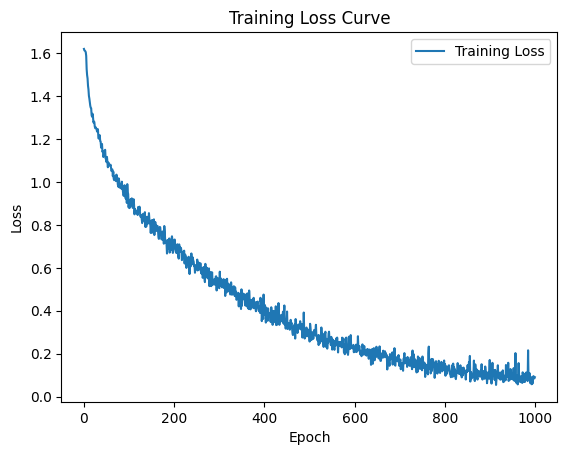

In [198]:
# Afficher la courbe de perte
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()